In [356]:
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import numpy as np
import markovify
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import *
from string import punctuation

In [306]:
STOPWORDS = stopwords.words('russian')

In [29]:
text = ''
for i in range(1, 5):
    with open(f'voyna-i-mir-tom-{i}.txt', encoding='utf-8') as f:
        text += (f.read() + '\n')

In [30]:
sentences = sent_tokenize(text)

In [46]:
original = pd.DataFrame(sentences)

In [47]:
original.rename(columns={0: 'text'}, inplace=True)

In [49]:
original['len'] = original['text'].apply(len)

In [50]:
original

,text,len
0,Лев Николаевич Толстой \nВойна и мир.,36
1,Том 1\n \n\n \nЛев Николаевич Толстой\...,122
2,Genes et Lucques ne sont plus que des apanages...,87
3,"Non, je vous previens, que si vous ne me dites...",305
4,"[ Ну, что, князь, Генуа и Лукка стали не боль...",83
...,...,...
31476,(сноска 10) нитями богородицы.,30
31477,(сноска 11) Вы нездоровы?,25
31478,(сноска 12) Нет.,16
31479,(сноска 13) Общественный договор.,33


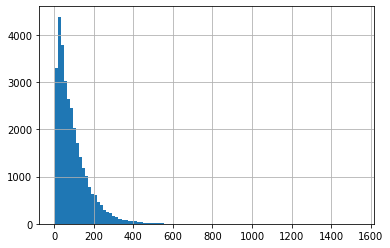

In [63]:
original['len'].hist(bins=100)

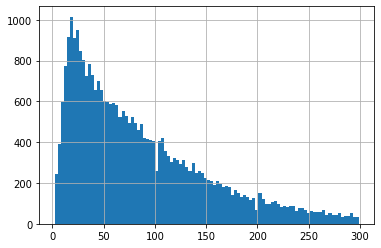

In [62]:
original[original['len'] < 300]['len'].hist(bins=100)

In [165]:
list(original['text'])[:10]

['Лев Николаевич Толстой \nВойна и мир.',
 'Том 1\n     \n\n     \nЛев Николаевич Толстой\nВОЙНА И МИР  \nТом 1\n     \nЧАСТЬ ПЕРВАЯ\n     \nI\n     \n     - Еh bien, mon prince.',
 'Genes et Lucques ne sont plus que des apanages, des поместья, de la famille Buonaparte.',
 "Non, je vous previens, que si vous ne me dites pas, que nous avons la guerre, si vous vous permettez encore de pallier toutes les infamies, toutes les atrocites de cet Antichrist (ma parole, j'y crois) - je ne vous connais plus, vous n'etes plus mon ami, vous n'etes plus мой верный раб, comme vous dites.",
 '[  Ну, что, князь, Генуа и Лукка стали не больше, как поместьями фамилии Бонапарте.',
 'Нет, я вас предупреждаю, если вы мне не скажете, что у нас война, если вы еще позволите себе защищать все гадости, все ужасы этого Антихриста (право, я верю, что он Антихрист) - я вас больше не знаю, вы уж не друг мой, вы уж не мой верный раб, как вы говорите.]',
 'Ну, здравствуйте, здравствуйте.',
 'Je vois que je vous fais 

In [66]:
with open('voyna-i-mir.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(list(original['text'])))

In [190]:
original['class'] = 'original'

In [191]:
original

,text,len,class
0,Лев Николаевич Толстой \nВойна и мир.,36,original
1,Том 1\n \n\n \nЛев Николаевич Толстой\...,122,original
2,Genes et Lucques ne sont plus que des apanages...,87,original
3,"Non, je vous previens, que si vous ne me dites...",305,original
4,"[ Ну, что, князь, Генуа и Лукка стали не боль...",83,original
...,...,...,...
31476,(сноска 10) нитями богородицы.,30,original
31477,(сноска 11) Вы нездоровы?,25,original
31478,(сноска 12) Нет.,16,original
31479,(сноска 13) Общественный договор.,33,original


In [69]:
# with open('voyna-i-mir.txt', encoding='utf-8') as f:
#     original_sentences = f.read()

In [70]:
original_model = markovify.NewlineText(original_sentences)

In [154]:
original_model.make_sentence()

'- II a deja tant souffert.'

In [160]:
%%time

generated = []
for i in range(7500):
    generated.append(original_model.make_sentence())

Wall time: 41.8 s


In [161]:
generated = pd.DataFrame(generated)

In [162]:
generated.rename(columns={0: 'text'}, inplace=True)

In [166]:
generated['class'] = 'generated'

In [167]:
generated

,text,class
0,"– Он помолчал, оглядываясь.",generated
1,"Напев разрастался, переходил из одного из солд...",generated
2,"Это был Анатоль Курагин, – сказала она, указыв...",generated
3,"- А, Бондаренко, друг сердечный, - проговорил ...",generated
4,- Наташа улыбнулась и хотела выйти из общей де...,generated
...,...,...
7495,"Я это могу рассказать вам ясно, потому что до ...",generated
7496,"В противном случае мы можем сделать из этого, ...",generated
7497,"Было уже поздно ночью, адъютанту Шнейдеру, - э...",generated
7498,"Но для того чтобы держать поводья, странно и п...",generated


In [179]:
X_train_generated, X_test_generated, y_train_generated, y_test_generated = train_test_split(
    generated['text'], generated['class'], test_size=0.1666, random_state=42)

In [184]:
X_test_generated

970     Все офицеры и люди и худые и добрые есть, - ск...
6279    Пьер с большим числом гостей сидела в переднем...
1859    К концу вечера, однако, по мере приближения к ...
6803    Он долго не мог обдумать и знать, что он запут...
6305    – спросила Наташа, хватая ее за руку, говоря е...
                              ...                        
1465    К собакам подскакали два охотника: один в яме ...
5843    С тем наивным убеждением развеселившихся молод...
2706    - M-lle Bourienne часто трогалась до слез, в в...
7314    Пьер подошел ближе и ближе еще, по низам и лес...
1321    Ну так, милое дитя мое, ты знаешь, что рано ил...
Name: text, Length: 1250, dtype: object

In [197]:
X_train_generated, X_val_generated, y_train_generated, y_val_generated = train_test_split(
    X_train_generated, y_train_generated, test_size=0.2, random_state=42)

In [199]:
X_val_generated

77      Иогель в первой линии, и неожиданно восторженн...
3827    - подумал князь Андрей; то, что делалось перед...
3766    Взгляд его оживлялся тем больше, чем присутств...
3598    Женитьба на богатой невесте и нежной дружбой и...
3726    Все искусные маневры, которые предлагали генер...
                              ...                        
6634    Dans le cas contraire, Votre Majeste, je me me...
2846    За ним следовала повозка, непохожая на все дру...
33                                     - Я не жил прежде.
3357    Благодаря такту, который выказывал князь Багра...
4611    - Я знаю твое сердце, - повторил он несколько ...
Name: text, Length: 1250, dtype: object

In [195]:
original_sample = original.sample(n=7500, random_state=42)

In [196]:
original_sample

,text,len,class
30910,Но новая история не сделала этого.,34,original
15499,"Что ж мне делать, Соня?",23,original
16466,Солнце уже поднялось и весело блестело на ярко...,55,original
23318,"Несколько секунд, пока молодой человек устанав...",90,original
8931,"Несколько раз, в продолжение утра, княжна Марь...",112,original
...,...,...,...
11597,IV\n \n Князь Андрей приехал в Петербу...,67,original
25198,"Это бледное, тонкое, печальное лицо, этот лучи...",202,original
24668,"Вы лихие враги, надо признаться.",32,original
19306,- Княжна вдруг заплакала.,25,original


In [215]:
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    original_sample['text'], original_sample['class'], test_size=0.1666, random_state=42)

In [220]:
X_test_original

11256    Во фраке и круглой шляпе Николай бродил по гор...
14767    Всё раздражение ее вдруг исчезло, и беспокойны...
25767    И, несмотря на то, его отношения к ней - остор...
16025    Она не улыбнулась, не кивнула ему головой, она...
24583    [(сноска 44)] Не удалась развязка театрального...
                               ...                        
19382    - А вы все слушайте меня, - Ростов обратился к...
7553                              - Так зачем же вы здесь?
31375    То, что я в следующую минуту не поднял руки, н...
1751                                   [  Это нам кстати.]
1635     Самое приятное для графа занятие, за исключени...
Name: text, Length: 1250, dtype: object

In [217]:
X_train_original, X_val_original, y_train_original, y_val_original = train_test_split(
    X_train_original, y_train_original, test_size=0.2, random_state=42)

In [218]:
X_val_original

11238    А ежели ты устал, пойдем в мою комнатку и ложи...
14221                        Пелагея Даниловна улыбнулась.
20016    - Да, а вон подальше и французы, - сказал офицер.
12111    Борис поцеловал руку Наташи и сказал, что он у...
4156     - Вы сказали, господин штаб-офицер, - продолжа...
                               ...                        
10881    Когда Ростов подъезжал к полку, он испытывал ч...
5464     - До свидания, голубчик, - сказал Тушин, - мил...
2240     Анна Михайловна старательно смотрела в глаза б...
1266     Глядя на свое красивое лицо, она стала, повиди...
2133     Это была одна из тех холодных и роскошных комн...
Name: text, Length: 1250, dtype: object

In [225]:
train_df = pd.concat(
    (pd.concat((X_train_original, y_train_original), axis=1),
    pd.concat((X_train_generated, y_train_generated), axis=1))
)
train_df = train_df.sample(frac=1, random_state=42)
train_df

,text,class
2043,"– Только с лошади-то не упадите, – прибавил он...",generated
4220,С моста поднялся густой дым.,original
6422,"Нельзя было ей лечь ни на бок, ни на грудь.",original
11681,"Всё равно как теперь, я вас спрашиваю, граф, к...",original
13826,"еще огонь в гостиной, – сказала она, указывая ...",original
...,...,...
2331,В Орле жило несколько пленных французских офиц...,generated
449,"Большинство присутствовавших были старые, почт...",generated
2958,"Неприятель перестал стрелять, и он, вставая, -...",generated
5934,"Ему было стыдно; ему казалось, что тут, подле ...",original


In [226]:
val_df = pd.concat(
    (pd.concat((X_val_original, y_val_original), axis=1),
    pd.concat((X_val_generated, y_val_generated), axis=1))
)
val_df = val_df.sample(frac=1, random_state=42)
val_df

,text,class
4789,Во время одного из них споткнулся.,generated
24039,"- Наташа, разденься, голубушка, ложись на мою ...",original
3486,Невольно он испытывал волнующее радостное чувс...,original
6719,"Нет, это не что иное, как изображение Песни пе...",generated
6490,Княгиня подошла к двери.,generated
...,...,...
4286,"Она, сама не могла понять их; но она сказала, ...",generated
17452,Она ощущала в душе своей благоговейный и трепе...,original
25540,"Но Пьер не понял его и стоял у столба, и никто...",original
1958,"Точно ту же мысль, но одно смущало ее.",generated


In [227]:
test_df = pd.concat(
    (pd.concat((X_test_original, y_test_original), axis=1),
    pd.concat((X_test_generated, y_test_generated), axis=1))
)
test_df = test_df.sample(frac=1, random_state=42)
test_df

,text,class
4622,"- Врешь, врешь, - закричал он, и зачем он тепе...",generated
22858,Я не хочу воспользоваться счастьем войны для у...,original
26380,"- Ах, право, поздно, - сказал граф Орлов, погл...",original
547,"Ребенок не верит, чтобы у вас эта чернопегая –...",generated
7027,Кутузов опять с грустной радостью она теперь в...,generated
...,...,...
5614,"Нам толкуют о правах женщин, об отношениях суп...",generated
5070,"Князь Андрей, запихавшись от быстроты езды, го...",original
24218,- Вы?,original
1726,"Он рассказывал то, что я ему такой обед задал…...",generated


In [228]:
X_train = train_df['text']
y_train = train_df['class']
X_val = val_df['text']
y_val = val_df['class']
X_test = test_df['text']
y_test = test_df['class']

In [260]:
%%time

pipe = Pipeline([('vectorizer', 
                TfidfVectorizer(ngram_range=(2, 3), tokenizer=word_tokenize, stop_words=STOPWORDS)), 
               ('logistic',
                LogisticRegression()
                )
              ])

# grid = GridSearchCV(
#     pipe,
#     param_grid={
#         'logistic__C': np.logspace(-3, 1, 5),
#         'logistic__penalty': ['l1', 'l2']
#     }
# )
# grid.fit(X_train, y_train)

pipe.fit(X_train, y_train)

c:\program files\python37\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 1.63 s


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(2, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как'...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function word_tokenize at 0x0000027630F43158>,
                                 use_idf=True, vocabulary=None)),
                ('logistic',
                 LogisticRegression(C=1.0, class_weight=None, 

In [255]:
print('2-3-grams, punctuation included')
print(f'Accuracy on train: {accuracy_score(y_train, pipe.predict(X_train))}')
print(f'Accuracy on test: {accuracy_score(y_test, pipe.predict(X_test))}')

2-3-Ngrams, punctuation included
Accuracy on train: 0.9884
Accuracy on test: 0.5376


In [267]:
print('2-3-grams, punctuation excluded')
print(f'Accuracy on train: {accuracy_score(y_train, pipe.predict(X_train))}')
print(f'Accuracy on test: {accuracy_score(y_test, pipe.predict(X_val))}')

2-3-Ngrams, punctuation excluded
Accuracy on train: 0.9869
Accuracy on test: 0.5092


In [354]:
%%time

pipe = Pipeline([('vectorizer', 
                TfidfVectorizer(analyzer='char', ngram_range=(1, 1))), 
               ('logistic',
                LogisticRegression(C=1)
                )
              ])

# grid = GridSearchCV(
#     pipe,
#     param_grid={
#         'logistic__C': np.logspace(-3, 1, 5),
#         'logistic__penalty': ['l1', 'l2']
#     }
# )
# grid.fit(X_train, y_train)

pipe.fit(X_train, y_train)

Wall time: 286 ms


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logistic',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept

In [355]:
print('Character 1-grams')
print(f'Accuracy on train: {accuracy_score(y_train, pipe.predict(X_train))}')
print(f'Accuracy on test: {accuracy_score(y_val, pipe.predict(X_val))}')

Character 1-grams
Accuracy on train: 0.6405
Accuracy on test: 0.6348


In [430]:
%%time

pipe = Pipeline([('vectorizer', 
                TfidfVectorizer(ngram_range=(2, 3), tokenizer=word_tokenize, stop_words=STOPWORDS)), 
               ('SVM',
                LinearSVC()
                )
              ])

# grid = GridSearchCV(
#     pipe,
#     param_grid={
#         'logistic__C': np.logspace(-3, 1, 5),
#         'logistic__penalty': ['l1', 'l2']
#     }
# )
# grid.fit(X_train, y_train)

pipe.fit(X_train, y_train)

Wall time: 1.81 s


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(2, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как'...
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function word_tokenize at 0x0000027630F43158>,
                                 use_idf=True, vocabulary=None)),
                ('

In [308]:
print('2-3-grams, punctuation included')
print(f'Accuracy on train: {accuracy_score(y_train, pipe.predict(X_train))}')
print(f'Accuracy on test: {accuracy_score(y_test, pipe.predict(X_test))}')

2-3-grams, punctuation included
Accuracy on train: 0.9973
Accuracy on test: 0.5264


In [345]:
%%time

pipe = Pipeline([('vectorizer', 
                TfidfVectorizer(analyzer='char', ngram_range=())), 
               ('SVM',
                LinearSVC(C=0.1)
                )
              ])

grid = GridSearchCV(
    pipe,
    param_grid={
#         'SVM__C': np.logspace(-3, 1, 5),
        'vectorizer__ngram_range': ((1, 1), (1, 3), (1, 5), (2, 3), (2, 5), (3, 5), (3, 7), (5, 7), (5, 10))
    }
)

# pipe.fit(X_train, y_train)
grid.fit(X_train, y_train)

c:\program files\python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Wall time: 1min 18s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='char',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(),
                                   

In [347]:
grid.best_params_

{'vectorizer__ngram_range': (1, 1)}

In [375]:
print('1-grams, punctuation included')
print(f'Accuracy on train: {accuracy_score(y_train, grid.predict(X_train))}')
print(f'Accuracy on validation: {accuracy_score(y_val, grid.predict(X_val))}')

1-grams, punctuation included
Accuracy on train: 0.6409
Accuracy on validation: 0.6332


In [428]:
print(f'Accuracy on test: {accuracy_score(y_test, grid.predict(X_test))}')

Accuracy on test: 0.6484


In [479]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

   generated       0.61      0.80      0.69      1250
    original       0.71      0.50      0.59      1250

    accuracy                           0.65      2500
   macro avg       0.66      0.65      0.64      2500
weighted avg       0.66      0.65      0.64      2500



In [387]:
original_model_3 = markovify.NewlineText(original_sentences, state_size=3)

In [419]:
%%time

X_test_generated_3 = []
for i in range(1250):
    X_test_generated_3.append(original_model_3.make_sentence(tries=100))

Wall time: 13.2 s


In [420]:
X_test_generated_3 = pd.DataFrame(X_test_3, columns=['text'])

In [421]:
X_test_generated_3['text'].isna().value_counts()

False    1250
Name: text, dtype: int64

In [422]:
X_test_generated_3['class'] = 'generated'

In [423]:
X_test_generated_3

,text,class
0,"Оттого ли, что тяготеет к земле, оттого ли, чт...",generated
1,Князь Андрей видел уже ясно растерянное и вмес...,generated
2,"Но глаза их, встретившись, сказали друг другу ...",generated
3,Императрица же Елизавета Алексеевна на вопрос ...,generated
4,"Но в последнее время, к недоуменью и удивлению...",generated
...,...,...
1245,Ростов с Ильиным в последний раз потешить девчат.,generated
1246,"– Знаю, верно про него думала, – сказал Никола...",generated
1247,"Охота пошла дальше, так как было слишком очеви...",generated
1248,"На лице его было что-то наивно-праздничное, да...",generated


In [474]:
X = X_test_generated_3['text']
y = X_test_generated_3['class']

In [424]:
test_3_df = pd.concat(
    (pd.concat((X_test_original, y_test_original), axis=1),
    X_test_generated_3)
)
test_3_df = test_3_df.sample(frac=1, random_state=42)
test_3_df

,text,class
197,"Волков этих что, говорит... - Та страженья был...",generated
22858,Я не хочу воспользоваться счастьем войны для у...,original
26380,"- Ах, право, поздно, - сказал граф Орлов, погл...",original
1037,"Я полагаю, что в том положении, в котором Рост...",generated
287,"Подъезжая к Смоленску, он слышал дальние выстр...",generated
...,...,...
388,"- Что это, мой друг, я боюсь, что не влезу на ...",generated
5070,"Князь Андрей, запихавшись от быстроты езды, го...",original
24218,- Вы?,original
44,"Угрелась, сукина дочь, - сказал он, вставая и ...",generated


In [425]:
X_test_3 = test_3_df['text']
y_test_3 = test_3_df['class']

In [478]:
print(classification_report(y_test_3, grid.predict(X_test_3)))

              precision    recall  f1-score   support

   generated       0.64      0.90      0.75      1250
    original       0.83      0.50      0.63      1250

    accuracy                           0.70      2500
   macro avg       0.74      0.70      0.69      2500
weighted avg       0.74      0.70      0.69      2500



In [457]:
original_model_1 = markovify.NewlineText(original_sentences, state_size=1)

In [464]:
%%time

X_test_generated_1 = []
for i in range(1250):
    X_test_generated_1.append(original_model_1.make_sentence(tries=100))

Wall time: 12.1 s


In [465]:
X_test_generated_1 = pd.DataFrame(X_test_generated_1, columns=['text'])

In [466]:
X_test_generated_1['text'].isna().value_counts()

False    1250
Name: text, dtype: int64

In [467]:
X_test_generated_1['class'] = 'generated'

In [468]:
X_test_generated_1

,text,class
0,Как потом подвели к каторжной работе.,generated
1,"В лице этого в которой он человек, но так мне ...",generated
2,"– Ну, видишь?",generated
3,"Анна Михайловна с каждым его страшным усилием,...",generated
4,"Пьер почувствовав, что князь Андрей для вас, н...",generated
...,...,...
1245,"Ах, Мари, как бы ему утешение, и будет.",generated
1246,"Она позволила себе подобных, точно так важно, ...",generated
1247,"- А папа держит под гору и стали слаживаться, ...",generated
1248,"Кроме того, что это не выказавший человеческог...",generated


In [469]:
test_1_df = pd.concat(
    (pd.concat((X_test_original, y_test_original), axis=1),
    X_test_generated_1)
)
test_1_df = test_1_df.sample(frac=1, random_state=42)
test_1_df

,text,class
197,"Мысли эти слова, пожимая ему нужно другое.",generated
22858,Я не хочу воспользоваться счастьем войны для у...,original
26380,"- Ах, право, поздно, - сказал граф Орлов, погл...",original
1037,Князь Николай слишком смело!,generated
287,Она сидела всё узнаем.,generated
...,...,...
388,Всё от рыданий и торопливо оглядывалась на нее.,generated
5070,"Князь Андрей, запихавшись от быстроты езды, го...",original
24218,- Вы?,original
44,La moitie des hommes!,generated


In [470]:
X_test_1 = test_1_df['text']
y_test_1 = test_1_df['class']

In [477]:
print(classification_report(y_test_1, grid.predict(X_test_1)))

              precision    recall  f1-score   support

   generated       0.57      0.66      0.61      1250
    original       0.60      0.50      0.54      1250

    accuracy                           0.58      2500
   macro avg       0.58      0.58      0.58      2500
weighted avg       0.58      0.58      0.58      2500



In [480]:
original_model_5 = markovify.NewlineText(original_sentences, state_size=5)

In [490]:
%%time

X_test_generated_5 = []
for i in range(1250):
    X_test_generated_5.append(original_model_5.make_sentence(tries=10000))

Wall time: 7min 38s


In [491]:
X_test_generated_5 = pd.DataFrame(X_test_generated_5, columns=['text'])

In [492]:
X_test_generated_5['text'].isna().value_counts()

False    1250
Name: text, dtype: int64

In [493]:
X_test_generated_5['class'] = 'generated'

In [494]:
X_test_generated_5

,text,class
0,"Я и тогда чувствовал, думал он, я чувствовал т...",generated
1,"Ростову, как от звуков самой веселой музыки, с...",generated
2,"Sire, - продолжал Паулучи с отчаянностью, как ...",generated
3,И он повернул лошадь и поскакал назад к тому м...,generated
4,"Если цель - величие Франции, то эта цель могла...",generated
...,...,...
1245,"Он тронул лошадь, скомандовал и в то же мгнове...",generated
1246,Наполеон позавтракал и опять стоял на том же м...,generated
1247,"Историки, по старой привычке признания божеств...",generated
1248,"Его нет, а есть тут же, на том же месте, где о...",generated


In [495]:
test_5_df = pd.concat(
    (pd.concat((X_test_original, y_test_original), axis=1),
    X_test_generated_5)
)
test_5_df = test_5_df.sample(frac=1, random_state=42)
test_5_df

,text,class
197,"Наполеон начал войну с Россией потому, что он ...",generated
22858,Я не хочу воспользоваться счастьем войны для у...,original
26380,"- Ах, право, поздно, - сказал граф Орлов, погл...",original
1037,С тех пор как Наташе в нынешнее утро сказали о...,generated
287,Частные историки биографические и историки отд...,generated
...,...,...
388,"- Как ты нагрела, однако, - сказал он, - ну, п...",generated
5070,"Князь Андрей, запихавшись от быстроты езды, го...",original
24218,- Вы?,original
44,"В первый раз Николай почувствовал, что мать не...",generated


In [496]:
X_test_5 = test_5_df['text']
y_test_5 = test_5_df['class']

In [497]:
print(classification_report(y_test_5, grid.predict(X_test_5)))

              precision    recall  f1-score   support

   generated       0.65      0.95      0.77      1250
    original       0.91      0.50      0.64      1250

    accuracy                           0.72      2500
   macro avg       0.78      0.72      0.71      2500
weighted avg       0.78      0.72      0.71      2500

